# Dunder Mifflin Acquisition Analysis

**Business Context:**  
Dunder Mifflin is considering acquiring Parch & Posey Paper Co., a smaller but fast-growing paper company. As a data analyst embedded in this initiative, you were tasked with conducting an exploratory data analysis (EDA) using SQL to help leadership evaluate the opportunity.

This analysis focuses on:
- Customer and regional footprint
- Product sales and revenue trends
- Staffing and operational gaps
- Key strategic recommendations before acquisition

Data is drawn from transactional and account-level records from 2013 to 2017.

# 1. Load SQL Extension and Connect to PostgreSQL (Code cell)

In [3]:
# access environment variables and create db engine and run sql queries

from dotenv import load_dotenv
load_dotenv("dunder.env")

import os
import pandas as pd
from sqlalchemy import create_engine

user = os.getenv('DB_USER')
password = os.getenv('DB_PASS')
host = os.getenv('DB_HOST')
port = os.getenv('DB_PORT')
dbname = os.getenv('DB_NAME')

connection_string = f'postgresql://{user}:{password}@{host}:{port}/{dbname}'

engine = create_engine(connection_string)

# Customer and Regional Footprint

Parch & Posey operates in **7 distinct regions** and serves **351 unique customer accounts**, highlighting a solid presence across multiple markets.

In [5]:
# total accounts

query = "SELECT COUNT(*) AS total_acts FROM accounts"

df = pd.read_sql(query, engine)

df

,total_acts
0,351


In [6]:
# total regions

query = "SELECT COUNT(*) as total_rgns FROM region"

df = pd.read_sql(query, engine)

df

,total_rgns
0,7


# Product Mix and Revenue Composition

Parch & Posey sells three types of paper: **Standard, Gloss, and Poster**. Standard accounts for over **50%** of total volume sold, while Gloss and Poster contribute more revenue per unit.

In [8]:
## Percentage of total quantity sold by paper type

query = """
SELECT
    SUM(standard_qty) AS std_total,
    SUM(gloss_qty) AS gloss_total,
    SUM(poster_qty) AS poster_total,
    100.0 * SUM(standard_qty) / SUM(total) AS pcntg_std,
    100.0 * SUM(gloss_qty) / SUM(total) AS pcntg_gloss,
    100.0 * SUM(poster_qty) / SUM(total) AS pcntg_poster
FROM orders """

df = pd.read_sql(query, engine)

df

,std_total,gloss_total,poster_total,pcntg_std,pcntg_gloss,pcntg_poster
0,1938346,1013773,723646,52.733132,27.579919,19.68695


In [9]:
# Revenue share by paper type

query = """
SELECT
    ROUND(SUM(standard_amt_usd) * 100.0 / SUM(total_amt_usd), 2) AS rev_pcntg_std,
    ROUND(SUM(gloss_amt_usd) * 100.0 / SUM(total_amt_usd), 2) AS rev_pcntg_gloss,
    ROUND(SUM(poster_amt_usd) * 100.0 / SUM(total_amt_usd), 2) AS rev_pcntg_poster
FROM orders """

df = pd.read_sql(query, engine)
df

,rev_pcntg_std,rev_pcntg_gloss,rev_pcntg_poster
0,41.8,32.81,25.39


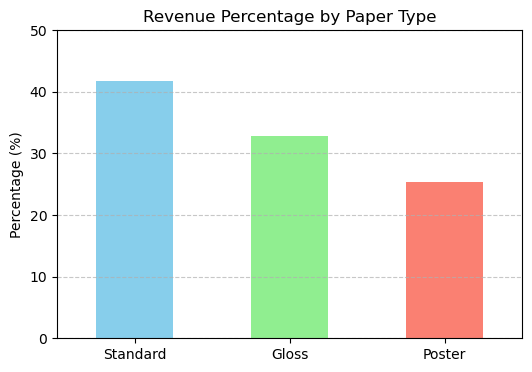

In [10]:
import matplotlib.pyplot as plt

# Extract the first row and convert to numeric
data = df.iloc[0].astype(float)

# Optional: Rename index for cleaner labels
data.index = ['Standard', 'Gloss', 'Poster']

# Plot
plt.figure(figsize = (6, 4))
data.plot(kind = 'bar', color = ['skyblue', 'lightgreen', 'salmon'])

plt.title('Revenue Percentage by Paper Type')
plt.ylabel('Percentage (%)')
plt.ylim(0, 50)
plt.xticks(rotation = 0)
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)

plt.show()


# Revenue and Volume Growth (2014–2016)

From 2014 to 2016, revenue **more than tripled** and unit sales rose over **200%**, demonstrating strong growth.

In [12]:
# Annual revenue by year

query = """
SELECT
    EXTRACT(YEAR FROM occurred_at) AS year,
    SUM(total_amt_usd) AS revenue
FROM orders
WHERE EXTRACT(YEAR FROM occurred_at) IN (2014, 2015, 2016)
GROUP BY year
ORDER BY year """

df = pd.read_sql(query, engine)
df

,year,revenue
0,2014.0,4069106.54
1,2015.0,5752004.94
2,2016.0,12864917.92


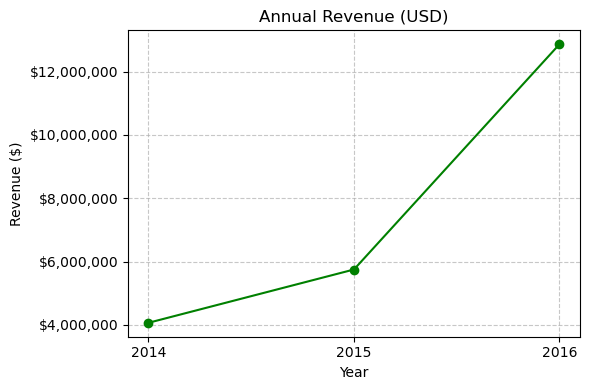

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# ensure year is treated as int and revenue as float
df['year'] = df['year'].astype(int)
df['revenue'] = df['revenue'].astype(float)

# plot
plt.figure(figsize = (6, 4))
plt.plot(df['year'], df['revenue'], marker = 'o', linestyle = '-', color = 'green')
    
plt.title('Annual Revenue (USD)')
plt.xlabel('Year')
plt.ylabel('Revenue ($)')
plt.grid(True, linestyle = '--', alpha = 0.7)
plt.xticks(df['year'])

# format y-axis ticks with commas, disable scientific notation
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"${x:,.0f}"))

plt.tight_layout()
plt.show()


In [14]:
# Annual units sold

query = """
SELECT
    EXTRACT(YEAR FROM occurred_at) AS year,
    SUM(total) AS units
FROM orders
WHERE EXTRACT(YEAR FROM occurred_at) IN (2014, 2015, 2016)
GROUP BY year
ORDER BY year """

df = pd.read_sql(query, engine)
df

,year,units
0,2014.0,650896
1,2015.0,912972
2,2016.0,2041600


# Sales Rep Allocation and Strategy

Some regions like **Northeast** are overstaffed (21 reps), while newer regions (North, South) lack coverage. Reallocation is needed.


In [16]:
# Sales reps by region

query = """
SELECT
    region.name,
    COUNT(sales_reps.id)
FROM sales_reps
RIGHT JOIN region ON sales_reps.region_id = region.id
GROUP BY region.name
ORDER BY region.name ASC """

df = pd.read_sql(query, engine)
df

,name,count
0,International,1
1,Midwest,9
2,North,0
3,Northeast,21
4,South,0
5,Southeast,10
6,West,10


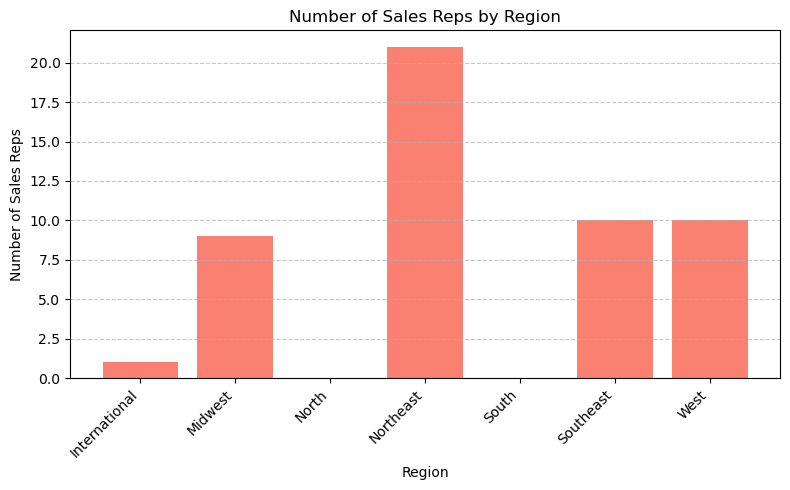

In [17]:
import matplotlib.pyplot as plt

# Rename columns for convenience if needed
df.columns = ['region', 'sales_rep_count']

plt.figure(figsize = (8, 5))
plt.bar(df['region'], df['sales_rep_count'], color = 'salmon')

plt.title('Number of Sales Reps by Region')
plt.xlabel('Region')
plt.ylabel('Number of Sales Reps')
plt.xticks(rotation = 45, ha = 'right')
plt.tight_layout()
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)

plt.show()

## 2016 Operational Summary

In [19]:
# Regional sales/rep/account summary for 2016

""" 
-- the total number of orders per region
-- the number of reps per region
-- the number of accounts per region
-- the total revenues per region
-- the average revenues per region 
"""

query = """
SELECT
    region.name AS region,
    COUNT(DISTINCT o.id) AS total_orders,
    COUNT(DISTINCT s.id) AS reps,
    COUNT(DISTINCT o.account_id) AS accounts,
    SUM(o.total_amt_usd) AS revenue,
    ROUND(AVG(o.total_amt_usd), 2) AS avg_order_revenue
FROM region
FULL JOIN sales_reps s ON region.id = s.region_id
FULL JOIN accounts a ON a.sales_rep_id = s.id
FULL JOIN orders o ON a.id = o.account_id
WHERE EXTRACT(YEAR FROM occurred_at) = 2016
GROUP BY region """

df = pd.read_sql(query, engine)
df

,region,total_orders,reps,accounts,revenue,avg_order_revenue
0,Midwest,483,9,41,1711747.25,3543.99
1,Northeast,1196,21,97,3999036.82,3343.68
2,Southeast,1110,10,86,3545487.49,3194.13
3,West,968,10,93,3608646.36,3727.94


In [20]:
"""
-- average number of orders per representative (across all representatives)
-- average number of accounts handled per representative (across all representatives)
-- average revenues per representative (across all representatives)
"""

# so from the previous output we will use that as a temp table with the WITH clause

query = """
WITH region_table AS (
	SELECT
		r.id AS region_id,
		r.name AS region_name,
		COUNT(DISTINCT o.id) AS total_orders_per_region,
		COUNT(DISTINCT s.id) AS reps_per_region,
		COUNT(DISTINCT o.account_id) AS accts_per_region,
		SUM(o.total_amt_usd) AS total_rev_per_region,
		ROUND(AVG(o.total_amt_usd), 2) AS avg_rev_perorder_perregion
	FROM region AS r
		JOIN sales_reps AS s ON r.id = s.region_id
		JOIN accounts AS a ON s.id = a.sales_rep_id
		JOIN orders AS o ON a.id = o.account_id
	WHERE EXTRACT(YEAR FROM occurred_at) = 2016
	GROUP BY r.id, r.name)

-- from main clause use math using alias from temp table
-- round avg orders, avg accounts to whole numbers because doesn't make sense to have partial
-- round avg rev to 2 decimal for monetary value
-- no need to group by bc temp table is already grouped by region_name

SELECT
	region_id,
	region_name,
    ROUND((total_orders_per_region)/(reps_per_region)) AS avg_orders_per_rep_across_all_reps,
    ROUND((accts_per_region)/(reps_per_region)) AS avg_accounts_per_rep_across_all_reps,
    ROUND((total_rev_per_region)/(reps_per_region), 2) AS avg_revenues_per_rep_across_all_reps
FROM
    region_table """

df = pd.read_sql(query, engine)
df

,region_id,region_name,avg_orders_per_rep_across_all_reps,avg_accounts_per_rep_across_all_reps,avg_revenues_per_rep_across_all_reps
0,1,Northeast,56.0,4.0,190430.32
1,2,Midwest,53.0,4.0,190194.14
2,3,Southeast,111.0,8.0,354548.75
3,4,West,96.0,9.0,360864.64


## Reallocation Recommendation

Consider moving 4–6 reps from the **Northeast** to **North and South** to support expansion without sacrificing current operations.

---

# Group vs Non-Group Accounts

Contrary to expectations, accounts ending in "Group" generate **lower average revenue** than non-group accounts.

In [23]:
# Classify and aggregate group status

query = """
WITH account_groups AS (
    SELECT
        a.id,
        a.name,
        CASE WHEN RIGHT(a.name, 5) ILIKE 'group' THEN 'Group' ELSE 'Not Group' END AS group_status,
        SUM(o.total_amt_usd) AS total_revenue
    FROM accounts a
    JOIN orders o ON a.id = o.account_id
    GROUP BY a.id, a.name)
    
SELECT
    group_status,
	  COUNT(*) AS num_accounts,
	  AVG(total_revenue) AS avg_revenue
FROM account_groups
GROUP BY group_status """

df = pd.read_sql(query, engine)
df

,group_status,num_accounts,avg_revenue
0,Not Group,332,66351.025482
1,Group,18,61831.742778


# Marketing Channel Optimization

In each legacy region, we identified the **least-used web event channel**, which can be deprioritized to free up resources.

In [25]:
# Least-used web event channel per region

query = """
SELECT
    region,
    channel,
    total_events
FROM (
  SELECT
      r.name AS region,
      w.channel,
      COUNT(*) AS total_events,
      RANK() OVER (PARTITION BY r.name ORDER BY COUNT(*) ASC) AS rnk
  FROM web_events w
  JOIN accounts a ON w.account_id = a.id
  JOIN sales_reps s ON a.sales_rep_id = s.id
  JOIN region r ON s.region_id = r.id
  GROUP BY r.name, w.channel ) AS sub
WHERE rnk = 1 """

df = pd.read_sql(query, engine)
df

,region,channel,total_events
0,Midwest,banner,59
1,Northeast,twitter,154
2,Southeast,twitter,127
3,West,banner,116


# Final Recommendations

- **Proceed with acquisition**: Revenue grew 3x in 2 years.
- **Reallocate sales reps**: Especially from Northeast to North/South.
- **Prioritize Gloss & Poster papers**: Higher revenue share.
- **Trim ineffective channels**: e.g., Twitter, Banner in old regions.

This strategic alignment will position Dunder Mifflin to scale Parch & Posey's operations efficiently post-acquisition.
